In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pylab as plt
%matplotlib inline
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

In [2]:
def plot_nobs_curve(filename, smooth_days=3):
    # runs avaialble at:  https://lsst-web.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.4/baseline/
    conn = sqlite3.connect('../baseline/'+filename)
    df = pd.read_sql('select night,filter,observationStartMJD from summaryallprops;', conn)
    conn.close()
    
    # Shift to March 21
    mjd0 = 60025
    
    day_shift = mjd0 - df['observationStartMJD'].min() 

    bins=np.arange(-1, df['night'].max()+1, 1)+0.5
    # number of observations per night. np.searchsorted would be faster
    n_obs, be, bn = binned_statistic(df['night'], df['night'], bins=bins, statistic=np.size)

    day_bins = np.arange(-1,367, smooth_days)+0.5
    new_bins = (bins[0:-1]+.5) % 365
    running_mean, be, bn = binned_statistic(new_bins, n_obs, bins=day_bins, statistic=np.mean)
    running_max, be, bn = binned_statistic(new_bins, n_obs, bins=day_bins, statistic=np.max)
    running_med, be, bn = binned_statistic(new_bins, n_obs, bins=day_bins, statistic=np.median)
    running_sd, be, bn = binned_statistic(new_bins, n_obs, bins=day_bins, statistic=np.std)

    shifted_x = (day_bins[0:-1]+.5 + day_shift) % 365
    
    order = np.argsort(shifted_x)
    shifted_x=shifted_x[order]
    running_mean = running_mean[order]
    running_max = running_max[order]
    running_med = running_med[order]
    
    plt.plot(shifted_x, running_mean, label='mean')
    plt.plot(shifted_x, running_max, label='max')
    plt.plot(shifted_x, running_med, label='median')
    plt.xlabel('Day of Year')
    plt.ylabel('N observations per night')
    plt.legend()
    plt.title(filename[:-4])
    return shifted_x, running_max

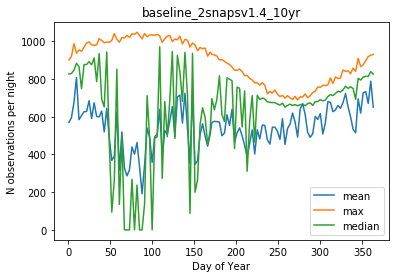

In [3]:
db1, rm1 = plot_nobs_curve('baseline_2snapsv1.4_10yrs.db')

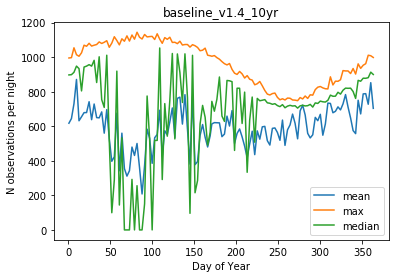

In [4]:
db2, rm2 = plot_nobs_curve('baseline_v1.4_10yrs.db')

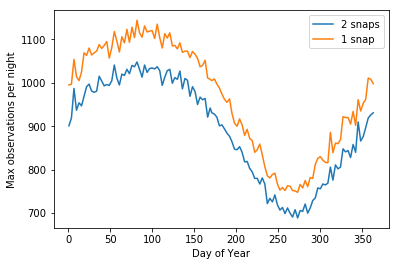

In [5]:
plt.plot(db1, rm1, label='2 snaps')
plt.plot(db2, rm2, label='1 snap')
plt.xlabel('Day of Year')
plt.ylabel('Max observations per night')
plt.legend()

In [6]:
def func(t,a,b,c):
    result = a+b*np.sin(2.*np.pi*(t+c)/365.)
    return result

[ 892.64768338  158.83173444    4.80248559]


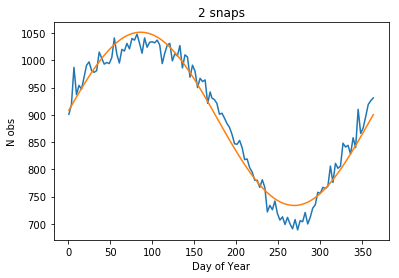

In [7]:
popt, pcov = curve_fit(func, db1, rm1)
plt.plot(db1, rm1)
plt.plot(db1, func(db1, *popt))
plt.xlabel('Day of Year')
plt.ylabel('N obs')
plt.title('2 snaps')
print(popt)

[ 964.9963713   172.63653876    4.95196249]


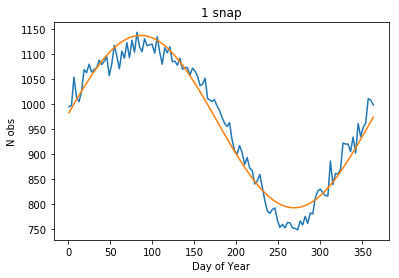

In [8]:
popt, pcov = curve_fit(func, db2, rm2)
plt.plot(db2, rm2)
plt.plot(db2, func(db2, *popt))
plt.xlabel('Day of Year')
plt.ylabel('N obs')
plt.title('1 snap')
print(popt)